In [93]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import os
from sklearn.ensemble import RandomForestClassifier


# Trova il percorso assoluto della cartella "esotic" (dove si trova il tuo ipynb)
current_dir = os.path.dirname(os.path.abspath("__file__"))

# Trova il percorso assoluto della cartella "lib"
lib_dir = os.path.join(current_dir, "..", "lib")

# Aggiungi il percorso di "lib" al PYTHONPATH
sys.path.append(lib_dir)

from Utility import *

features = [
'RecentFormRatio', 'EloRatio'
]


features = [
 'ATW_LogRegPred'
]

features2 = ['UltimoScontroDiretto', 'feat1', 'feat2']

classWeight={1: 1, 0: 2}

## DATA

In [94]:
data = getCompleteATWData().copy()
# data = pd.read_excel('../data/mergedSerieA.xlsx')

dataU = data.dropna(subset=features2)


## Feature Engineering

In [95]:
data = data.dropna(subset=features)
print(len(data), len(dataU))
# data = data.dropna()
print(len(data))
data['isOver'] = np.where(data['MatchGoal'] > 2.5, 1, 0)
data['isATS'] = np.where(((data['FTAG'] > 0)), 1, 0)
print('isATS:', round(100*data[data['isATS']==1]['isATS'].count() / len(data['isATS'])), '%')
x_train, x_test, y_train, y_test = train_test_split(
    data[features], data['isATS'], test_size=0.3, random_state=42, shuffle=True)#, stratify=data['isATS'])

x_train = x_train.sort_index()
x_test = x_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()


print(f'X_train: {x_train.shape} \nX_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}')

38192 19770
38192
isATS: 67 %
X_train: (26734, 1) 
X_test: (11458, 1) 
y_train: (26734,) 
y_test: (11458,)


## Models

### Decision Tree model

In [96]:
from sklearn.tree import DecisionTreeClassifier



# Crea e addestra il modello di albero di decisione per la regressione
decTreeModel = DecisionTreeClassifier(random_state=42, min_samples_split=80
                                 , class_weight=classWeight
                                 # , class_weight='balanced'
                                 , max_depth=3  # , ccp_alpha= 0.00001
                                 # , max_features= 3
                                 ).fit(x_train, y_train)

# decTreeModel = RandomForestClassifier(random_state=42, n_estimators=100, 
#                                 min_samples_split=80, max_depth=3).fit(x_train_under, y_train_under) 

# dumpModel("Step1.joblib", decTreeModel)
# decTreeModel = loadModel("Step1.joblib")

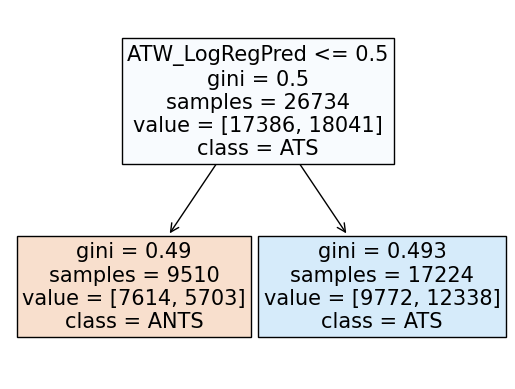

In [102]:
from sklearn import tree

class_mapping = {
    0: "ANTS",
    1: "ATS"
}


tree.plot_tree(decTreeModel, feature_names=features, filled=True, fontsize=15               # ,proportion=True  # Mostra la proporzione delle classi
               , class_names=pd.Series(decTreeModel.classes_).map(class_mapping) #['Away', 'Home',  'Draw']
               )
plt.show()

### LogisticRegression

In [97]:
logRegModel = trainLogRegModel(x_train, y_train, class_weight=classWeight)

# dumpModel("Step1LogReg.joblib", logRegModel_u)
# rfModel = loadModel('Step1LogReg.joblib')

### Random Forest

In [98]:
# Crea e addestra il modello di Random Forest


from sklearn.model_selection import GridSearchCV

rfModel = RandomForestClassifier(random_state=42, n_estimators=200, 
                                min_samples_split=80, max_depth=3
                                # class_weight='balanced_subsample'
                                 , class_weight=classWeight
                                ).fit(x_train, y_train) 


# param_grid = {
#     'n_estimators': [200],
#     'min_samples_split': [50, 100],
#     'max_depth': [3, 5],
# }

# grid_search = GridSearchCV(estimator=rfModel, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(x_train, y_train)

# print("Migliori iperparametri:", grid_search.best_params_)
# print("Migliore accuratezza:", grid_search.best_score_)

# best_rfModel = grid_search.best_estimator_

# rfModel = best_rfModel


# dumpModel("ATS-RF.joblib", rfModel)
# rfModel = loadModel('ATS-RF.joblib')

In [99]:
from sklearn.multiclass import OneVsRestClassifier

# Crea un classificatore One-vs-Rest usando Logistic Regression come classificatore base
ovr_classifier = OneVsRestClassifier(LogisticRegression())

# Addestra il classificatore
ovr_classifier.fit(x_train, y_train)


OneVsRestClassifier(estimator=LogisticRegression())

## Utility Func for Gain

In [100]:
quotaMin = 1.4

def calculate_gain_ReverseATS(row, prediction):
    if (row[prediction] == 1):
        if row['QuotaANTS'] > quotaMin :
            if row['FTAG'] == 0:
                return row['QuotaANTS']-1
            else:
                return -1
        else:
            return 0
    else:
        return 0
    
def calculate_gain_ANTS(row, prediction):
    if (row[prediction] == 0):
        if row['QuotaANTS'] > quotaMin :
            if row['FTAG'] == 0:
                return row['QuotaANTS']-1
            else:
                return -1
        else:
            return 0
    else:
        return 0
    
def calculate_gain_ATS(row, prediction):
    if (row[prediction] == 1):
        if row['QuotaATS'] > quotaMin :
            if row['FTAG'] > 0:
                return row['QuotaATS']-1
            else:
                return -1
        else:
            return 0
    else:
        return 0
    
def calculate_gain_BTS(row, prediction):
    if (row[prediction] == 1):
        if row['BTS'] > quotaMin :
            if row['FTHG'] > 0 and row['FTAG'] > 0:
                return row['BTS']-1
            else:
                return -1
        else:
            return 0
    else:
        return 0
def calculate_gain_O25(row, prediction):
    
    if (row[prediction] == 1):
        if row['B365>2.5'] > quotaMin :
            if row['MatchGoal'] > 2.5:
                return row['B365>2.5']-1
            else:
                return -1
        else:
            return 0
    elif (row[prediction] == 0): 
        if row['B365<2.5'] > quotaMin :
            if row['MatchGoal'] < 2.5:
                return row['B365<2.5']-1
            else:
                return -1
        else:
            return 0
    else:
        return 0

def calculate_gain_Over25(row, prediction):
    # print('row', row['B365>2.5'], pd.isna(row['B365>2.5']))
    if (row[prediction] == 1):
        # return 0
        if row['B365>2.5'] > quotaMin :
            if row['MatchGoal'] > 2.5:
                return row['B365>2.5']-1
            else:
                return -1
        else:
            return 0
    else:
        return 0
    
def calculate_gain_Under25(row, prediction):
    if (row[prediction] == 0): 
        # return 0
        if row['B365<2.5'] > quotaMin :
            if row['MatchGoal'] < 2.5:
                return row['B365<2.5']-1
            else:
                return -1
        else:
            return 0
    else:
        return 0

## Metrics

In [101]:
from itertools import count
from math import nan
from sklearn.metrics import accuracy_score

df_train = data[data.index.isin(x_train.index)].copy()
print(len(df_train))

df_train['LogRegPred'] = logRegModel.predict(x_train)
df_train['DecTreePred'] = decTreeModel.predict(x_train)
df_train['RFPred'] = rfModel.predict(x_train)


df_test = data[data.index.isin(x_test.index)].copy()

print(len(df_test))

df_test['LogRegPred'] = logRegModel.predict(x_test)
df_test['DecTreePred'] = decTreeModel.predict(x_test)
df_test['RFPred'] = rfModel.predict(x_test)
df_test['1vsAllPred'] = ovr_classifier.predict(x_test)
df_test['FullPred'] = np.where(df_test['RFPred']+df_test['LogRegPred'] ==2, 1, 0)

print(
    f"Test LogReg Accuracy score: {round(100*accuracy_score(y_test, df_test['LogRegPred']),2)}%")
print(
    f"Test DecTree Accuracy score: {round(100*accuracy_score(y_test, df_test['DecTreePred']),2)}%")
print(
    f"Train Random Forest Accuracy score: {round(100*accuracy_score(y_train, df_train['RFPred']),2)}%")
print(
    f"Test Random Forest Accuracy score: {round(100*accuracy_score(y_test, df_test['RFPred']),2)}%")
print(
    f"Test OneVsAll Accuracy score: {round(100*accuracy_score(y_test, df_test['1vsAllPred']),2)}%")
print(
    f"Test FullPred Accuracy score: {round(100*accuracy_score(y_test, df_test['FullPred']),2)}%")


models = ['LogReg', 'RF', 'DecTree', '1vsAll']
rows = []
classAccuracyDf = pd.DataFrame(
    columns=['Modello', 'Accuratezza_Under', 'Accuratezza_Over'])
for model in models:
    row = {
        "Modello": model,
        "Accuratezza_Over": class_accuracy(y_test, df_test[model+'Pred'])['Over'],
        "Accuratezza_Under": class_accuracy(y_test, df_test[model+'Pred'])['Under']
    }
    rows.append(row)

classAccuracyDf = pd.DataFrame(rows)
classAccuracyDf.set_index('Modello', inplace=True)

print('')
print(classAccuracyDf)


# Ottieni le probabilità predette per ogni classe
probabilita = logRegModel.predict_proba(x_test)

# 
prediction = '1vsAllPred'
prediction = 'LogRegPred'
prediction = 'RFPred'
# prediction = 'DecTreePred'

df_test['QuotaA'] = df_test['B365A'].fillna(df_test['AvgCA'].fillna(df_test['AvgA']))

df_test['PA'] =  1/df_test['QuotaA']
df_test['PATS'] = df_test['PA']**(1/4.8)#+0.003/df_test['PA']
df_test['PANTS'] = 1-df_test['PATS']
df_test['QuotaATS'] = 1/df_test['PATS']
df_test['QuotaANTS'] = 1/df_test['PANTS']
df_test['QuotaANTS'] = df_test['QuotaANTS']*0.8

df_test['GainATS'] = df_test.apply(calculate_gain_ATS, axis=1, args=(prediction,) )
df_test['GainANTS'] = df_test.apply(calculate_gain_ANTS, axis=1, args=(prediction,) )
df_test['GainReverseATS'] = df_test.apply(calculate_gain_ReverseATS, axis=1, args=(prediction,) )

# df_test['Gain'] = df_test['GainOver'].loc(-1)+ df_test_under['GainUnder'].loc(-1) 
# df_test['Equity'] = df_test['Gain'].cumsum()
df_test['EquityATS'] = df_test['GainATS'].cumsum()
df_test['EquityANTS'] = df_test['GainANTS'].cumsum()
df_test['EquityRevATS'] = df_test['GainReverseATS'].cumsum()

# print(df_test['Equity'].tail(1))
print('Equity ATS', df_test['EquityATS'].tail(1))
print('Equity ANTS', df_test['EquityANTS'].tail(1))
print('Equity Reverse ATS', df_test['EquityRevATS'].tail(1))

from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(df_test['BTS'], df_test[prediction])
# print(cm)

# print(df_test)
# exportExcelWithTimeStamp(df_test, "../Dataframe/", "df.xlsx")

26734
11458
Test LogReg Accuracy score: 60.02%
Test DecTree Accuracy score: 60.02%
Train Random Forest Accuracy score: 60.39%
Test Random Forest Accuracy score: 60.02%
Test OneVsAll Accuracy score: 67.14%
Test FullPred Accuracy score: 60.02%

         Accuratezza_Over  Accuratezza_Under
Modello                                     
LogReg           0.713268            0.40197
RF               0.713268            0.40197
DecTree          0.713268            0.40197
1vsAll           0.671409                NaN


c:\Users\vitto\OneDrive\Desktop\Personale\ML - Soccer\BothToScore\..\lib\Utility.py:285: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0])
c:\Users\vitto\OneDrive\Desktop\Personale\ML - Soccer\BothToScore\..\lib\Utility.py:285: RuntimeWarning: invalid value encountered in scalar divide
  accuracy_class_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0])


Equity ATS 38191   -59.711182
Name: EquityATS, dtype: float64
Equity ANTS 38191    390.566449
Name: EquityANTS, dtype: float64
Equity Reverse ATS 38191    1525.536425
Name: EquityRevATS, dtype: float64
